# Preliminary Investigations

## Environment preparation

### Imports

In [1]:
import sys
sys.path.append('/app/Projects/transformer_wrappers/src')

In [2]:
from itertools import product

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
import numpy as np

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

/home/vincenzoscotti/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformer_wrappers.wrappers import ParallelModelWrapper, ParallelModelWrapperForCausalLMWrapper
from transformer_wrappers.wrappers import RecursiveModelWrapper, RecursiveModelWrapperForCausalLMWrapper

### Constants

In [7]:
COLOURS = [f'C{i}' for i in range(10)]
STYLES = ['solid', 'dotted', 'dashed', 'dashdot']

In [8]:
MODEL = 'gpt2-xl'  # 'meta-llama/Llama-2-7b'
MODEL_CONFIGS = {
    'torch_dtype': torch.bfloat16
}

In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

### Global

In [12]:
input_string = 'The quick brown fox jumps over the lazy dog.'

## Experiments

### Transformer

#### Baseline

In [17]:
model = AutoModel.from_pretrained(MODEL, **MODEL_CONFIGS).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [20]:
input_encodings = tokenizer(input_string, return_tensors='pt').to(DEVICE)

In [21]:
output = model(
    **input_encodings, 
    return_dict=True, 
    output_attentions=False, 
    use_cache=False, 
    output_hidden_states=False
)

#### Parallel

##### Processing

In [56]:
model = ParallelModelWrapper.from_pretrained(MODEL, model_kwargs=MODEL_CONFIGS).to(DEVICE)

In [57]:
input_encodings = model.tokenizer(input_string, return_tensors='pt').to(DEVICE)

In [58]:
output_parallel = dict()

In [59]:
for b in range(len(model.layers)):
    if b > 0 and len(model.layers) % b == 0:
        output_parallel[b] = model(
            **input_encodings, 
            blocks=b,
            return_dict=True, 
            output_attentions=False, 
            use_cache=False, 
            output_hidden_states=False
        )

##### Analysis

In [60]:
diff = {
    k: (output_parallel[k].last_hidden_state - output.last_hidden_state).norm(dim=-1).squeeze()
    for k in output_parallel
}

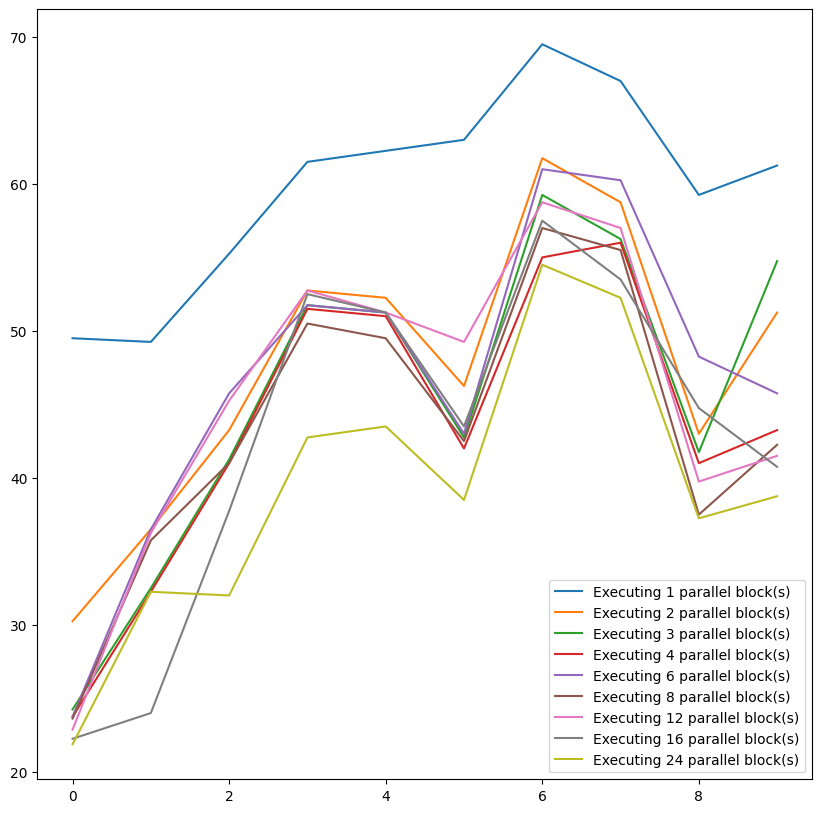

In [61]:
fig = plt.figure(figsize=(10, 10))
for (k, values), (s, c) in zip(diff.items(), product(STYLES, COLOURS)):
    values = values.detach().float().cpu().numpy()
    plt.plot(np.arange(len(values)), values, color=c, linestyle=s, label=f'Executing {k} parallel block(s)')
plt.legend(loc='best')
plt.show()

#### Recursive

##### Processing

In [42]:
model = RecursiveModelWrapper.from_pretrained(MODEL, model_kwargs=MODEL_CONFIGS).to(DEVICE)

In [43]:
input_encodings = model.tokenizer(input_string, return_tensors='pt').to(DEVICE)

In [44]:
output_recursive = dict()

In [45]:
for i in range(1, len(model.layers) + 1):
    n = [1] * (len(model.layers) - i) + [2] * i
    output_recursive[i] = model(
        **input_encodings, 
        iterations=n,
        return_dict=True, 
        output_attentions=False, 
        use_cache=False, 
        output_hidden_states=False
    )

##### Analysis

In [46]:
diff = {
    k: (output_recursive[k].last_hidden_state - output.last_hidden_state).norm(dim=-1).squeeze()
    for k in output_recursive
}

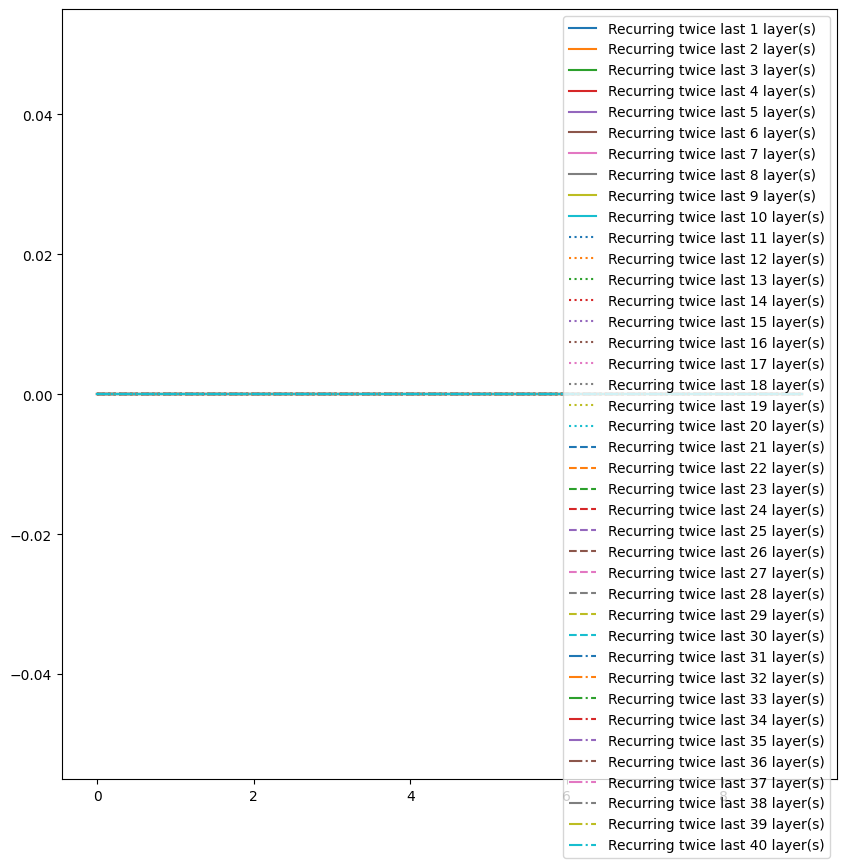

In [47]:
fig = plt.figure(figsize=(10, 10))
for (k, values), (s, c) in zip(diff.items(), product(STYLES, COLOURS)):
    values = values.detach().float().cpu().numpy()
    plt.plot(np.arange(len(values)), values, color=c, linestyle=s, label=f'Recurring twice last {k} layer(s)')
plt.legend(loc='best')
plt.show()

In [48]:
for k, values in diff.items():
    values = values.detach().float().cpu().numpy()
    print(f'Recurring twice last {k} layer(s): mean = {values.mean():.4f}, std = {values.std():.4f}')

Recurring twice last 1 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 2 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 3 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 4 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 5 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 6 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 7 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 8 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 9 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 10 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 11 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 12 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 13 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 14 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 15 layer(s): mean = 0.0000, std = 0.0000
Recurring twice last 16 layer(s): mean = 0.0000, std = 0.0000
Recurring twice l